![encodelogo](images/encodelogo.gif)

# Exploring ENCODE data from EC2 with Jupyter notebook

This notebook demonstrates how to mount *s3://encode-public* on an EC2 instance using [Goofys](https://github.com/kahing/goofys). Goofys makes an S3 bucket appear as a typical UNIX file system, and is useful for tools that expect a local file path. Once the bucket is mounted we can launch a Jupyter notebook on the instance and connect to it remotely. The benefit of using EC2 is that the compute is scalable to the analysis you would like to perform, and you don't have to download anything locally.

# Spin up instance

We will log into our AWS console and start an EC2 instance from a base Ubuntu image (it is also possible to find images that include most of the dependencies that we will install manually below).

1) Go to EC2 instances.

![launch1](images/ec2_goofys_jupyter/launch1.png)

2) Click launch instance.

![launch2](images/ec2_goofys_jupyter/launch2.png)

3) Choose base Ubuntu image.

![launch3](images/ec2_goofys_jupyter/launch3.png)

4) Choose instance type.

![launch4](images/ec2_goofys_jupyter/launch4.png)

5) Add key pair.

![launch5](images/ec2_goofys_jupyter/launch5.png)

For this example we will use `t2.xlarge` instance size. Make sure to provide or create a key pair for your instance so we can SSH on later.

# SSH into the instance

Search for the instance you just created and find its public DNS.

![launch6](images/ec2_goofys_jupyter/launch6.png)

Open a terminal and connect to the instance using SSH, filling in your secret key and instance address:
```
$ ssh -i ~/.ssh/keenan.pem ubuntu@ec2-54-191-241-6.us-west-2.compute.amazonaws.com
```

# Install dependencies

We will install:

[Anaconda](https://www.anaconda.com/distribution/)
```
$ curl -O https://repo.anaconda.com/archive/Anaconda3-2019.03-Linux-x86_64.sh
$ bash Anaconda3-2019.03-Linux-x86_64.sh
$ source ~/.bashrc
$ conda create -n encode-public python=3.7
$ conda activate encode-public
```

[awscli](https://github.com/aws/aws-cli)
```
$ pip install awscli
```

[Jupyter notebook](https://jupyter.org/)
```
$ conda install jupyter
```

[pandas](https://pandas.pydata.org/)
```
$ conda install pandas
```

[seaborn](https://seaborn.pydata.org/)
```
$ conda install seaborn
```

[pyBigWig](https://github.com/deeptools/pyBigWig)
```
$ conda install pybigwig -c bioconda
```

[Go](https://golang.org/)
```
$ sudo apt-get update
$ sudo apt-get install golang-go
```


[Goofys](https://github.com/kahing/goofys)
```
$ export GOPATH=$HOME/work
$ go get github.com/kahing/goofys
$ go install github.com/kahing/goofys
```

[Tree](http://manpages.ubuntu.com/manpages/trusty/man1/tree.1.html)
```
$ sudo apt-get install tree
```

# Mount S3 bucket

Goofys expects valid AWS credentials (though they don't need to have permission to do anything since we are mounting a public bucket). Run `aws configure` and enter your *aws_access_key_id*, *aws_secret_access_key*, and default region (e.g. `us-west-2`).

Mount *s3://encode-public* to local folder called *encode-public*:

```
$ mkdir encode-public
$ $GOPATH/bin/goofys encode-public/ encode-public/
```

# Start Jupyter notebook

Now we can run a Jupyter notebook on the EC2 instance and connect to it remotely.
```
$ jupyter notebook --no-browser --port=8888
```
Note the token in the returned URL (e.g. http://localhost:8888/?token=213b9a2799fe83807ab9e2e1254677ed3eb82cea9d05f452).

# Link local port to remote port

Open another terminal window and type (again filling in your details):

```
$ ssh -i ~/.ssh/keenan.pem -L 8000:localhost:8888 ubuntu@ec2-54-191-241-6.us-west-2.compute.amazonaws.com
```

This links your local 8000 port to the Jupyter notebook running on port 8888 of your EC2 instance. Launch a browser and type in `localhost:8000`. You should see a Jupyter window asking you for the token from above.

![launch5](images/ec2_goofys_jupyter/launch7.png)

# Create notebook

Create a new Jupyter notebook using Python 3.

![launch8](images/ec2_goofys_jupyter/launch8.png)

# Explore bucket structure

In the notebook we can `ls` the *encode-public* folder to list the contents of the S3 bucket.

In [1]:
!ls encode-public/

2008  2010  2012  2014	2016  2018  encode_file_manifest.tsv
2009  2011  2013  2015	2017  2019  robots.txt


We can see that the files are organized by year/month/day and that there is a TSV file manifest. To get a better idea of the structure we can use `tree` to recursively iterate through the 2008 files.

In [19]:
!tree encode-public/2008 | head

encode-public/2008
└── 11
    └── 24
        ├── 034e3689-9903-4c86-9237-040f8f795b73
        │   └── ENCFF001SNN.broadPeak.gz
        ├── 0868284e-8c3c-488d-89e6-487cd89971c3
        │   └── ENCFF000AAU.broadPeak.bigbed
        ├── 0b903d8b-824c-4e34-9b24-a1d23e31d83f
        │   └── ENCFF001SNC.broadPeak.gz
        ├── 0e0d13f7-4e7c-4cee-95a8-e3dc1c1351d1


Notice that every file is identified by a UUID (e.g. 034e3689-9903-4c86-9237-040f8f795b73) and accession (e.g. ENCFF001SNN). In addition to the file manifest you can always append the UUID or accession to the end of https://www.encodeproject/ to get more information about the file.

For example these are equivalent:
* https://www.encodeproject.org/034e3689-9903-4c86-9237-040f8f795b73
* https://www.encodeproject.org/ENCFF001SNN

# Open ENCODE bigWig using local path

The nice thing about having a Jupyter notebook running on the EC2 instance is that we can open the file manfiest directly in *pandas*.

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyBigWig
import seaborn as sns

Open the tab-delimited manifest.

In [4]:
files = pd.read_csv('encode-public/encode_file_manifest.tsv', sep='\t')

Every row is a file (~400,000 files in the bucket).

In [5]:
files.shape

(412361, 18)

The columns contain important metadata about the files, such as their format and full S3 key.

In [6]:
files.columns

Index(['accession', 'status', 'file_format', 'file_type', 'assembly',
       'award.rfa', 's3_uri', 'cloud_metadata.url', 'dataset', 'lab.@id',
       'output_type', 'output_category', 'file_size', 'date_created', 'md5sum',
       'cloud_metadata.md5sum_base64', 'replicate_libraries',
       'analysis_step_version.analysis_step.name'],
      dtype='object')

We can see how many files there are by format.

In [7]:
files.file_format.value_counts()

bigWig      126742
bam          78986
bed          70165
bigBed       65757
fastq        47718
tsv          15459
tagAlign      2268
tar           1657
gtf           1125
gff            720
idat           554
hdf5           280
rcc            227
sam            188
wig            188
hic            160
csfasta         49
csqual          37
vcf             37
fasta           27
bedpe            9
CEL              8
Name: file_format, dtype: int64

We can also filter the manifest to only include select files. For example all the GRCh38 bigWigs from [ENCSR901SIL](https://www.encodeproject.org/experiments/ENCSR901SIL/), a H3K4me3 ChIP-seq experiment in heart tissue.

In [8]:
filtered_files = files[
    (files.dataset == '/experiments/ENCSR901SIL/')
    & (files.file_format == 'bigWig')
    & (files.assembly == 'GRCh38')
].reset_index(drop=True)
filtered_files[['accession', 'dataset', 'file_format', 'assembly', 'output_type', 's3_uri']]

,accession,dataset,file_format,assembly,output_type,s3_uri
0,ENCFF254JZR,/experiments/ENCSR901SIL/,bigWig,GRCh38,fold change over control,s3://encode-public/2017/03/21/e8e286f4-14a2-4c...
1,ENCFF112WFU,/experiments/ENCSR901SIL/,bigWig,GRCh38,signal p-value,s3://encode-public/2017/03/21/52a1bef1-d28c-4e...


By removing the *s3://* from the s3_uri we will have the file paths to our locally mounted bucket.

In [9]:
filtered_files['local_path'] = filtered_files.s3_uri.apply(lambda x: x.replace('s3://', ''))

Now we can open the signal p-value bigWig using `pyBigWig` and the local path. 

In [10]:
path_to_ENCFF112WFU = filtered_files.iloc[1].local_path
path_to_ENCFF112WFU

'encode-public/2017/03/21/52a1bef1-d28c-4e7e-849d-c7fa4da3c589/ENCFF112WFU.bigWig'

In [11]:
bw = pyBigWig.open(path_to_ENCFF112WFU)

# Explore bigWig file

In order to consider only the canonical chromosomes we will quickly filter our bigWig by chromosome name length.

In [46]:
chroms = bw.chroms()
filtered_chroms = {
    k: v
    for k, v in chroms.items()
    if len(k) < 10
}
filtered_chroms

{'chr13': 114364328,
 'chr12': 133275309,
 'chr10': 133797422,
 'chr17': 83257441,
 'chr16': 90338345,
 'chr15': 101991189,
 'chr19': 58617616,
 'chr18': 80373285,
 'chr5': 181538259,
 'chr11': 135086622,
 'chr14': 107043718,
 'chr4': 190214555,
 'chr2': 242193529,
 'chrY': 57227415,
 'chrX': 156040895,
 'chrM': 16569,
 'chr22': 50818468,
 'chr20': 64444167,
 'chr21': 46709983,
 'chr7': 159345973,
 'chr6': 170805979,
 'chr3': 198295559,
 'chr1': 248956422,
 'chr9': 138394717,
 'chr8': 145138636}

And sort by chromosome number.

In [25]:
def sort_by_chromosome(x):
    chrom_number = x.replace('chr', '')
    try:
        return int(chrom_number)
    except:
        return np.inf

In [47]:
sorted_chroms = sorted(((k, v) for k, v in filtered_chroms.items()), key=lambda x: sort_by_chromosome(x[0]))
sorted_chroms

[('chr1', 248956422),
 ('chr2', 242193529),
 ('chr3', 198295559),
 ('chr4', 190214555),
 ('chr5', 181538259),
 ('chr6', 170805979),
 ('chr7', 159345973),
 ('chr8', 145138636),
 ('chr9', 138394717),
 ('chr10', 133797422),
 ('chr11', 135086622),
 ('chr12', 133275309),
 ('chr13', 114364328),
 ('chr14', 107043718),
 ('chr15', 101991189),
 ('chr16', 90338345),
 ('chr17', 83257441),
 ('chr18', 80373285),
 ('chr19', 58617616),
 ('chr20', 64444167),
 ('chr21', 46709983),
 ('chr22', 50818468),
 ('chrY', 57227415),
 ('chrX', 156040895),
 ('chrM', 16569)]

We can plot the number of bases by chromosome.

In [53]:
def make_bar_chart(data, xlab=None, ylab=None, title=None, rot=45, figsize=[14, 10]):
    plt.figure(figsize=figsize)
    df = pd.DataFrame(data)
    ax = sns.barplot(
        x=0,
        y=1,
        data=df,
        color='black',
        linewidth=2.5,
        facecolor=(1, 1, 1, 0),
        edgecolor=".2"
    )
    if xlab:
        ax.set_xlabel(xlab)
    if ylab:
        ax.set_ylabel(ylab)
    if title:
        plt.title(title)
    plt.xticks(rotation=rot)
    return ax

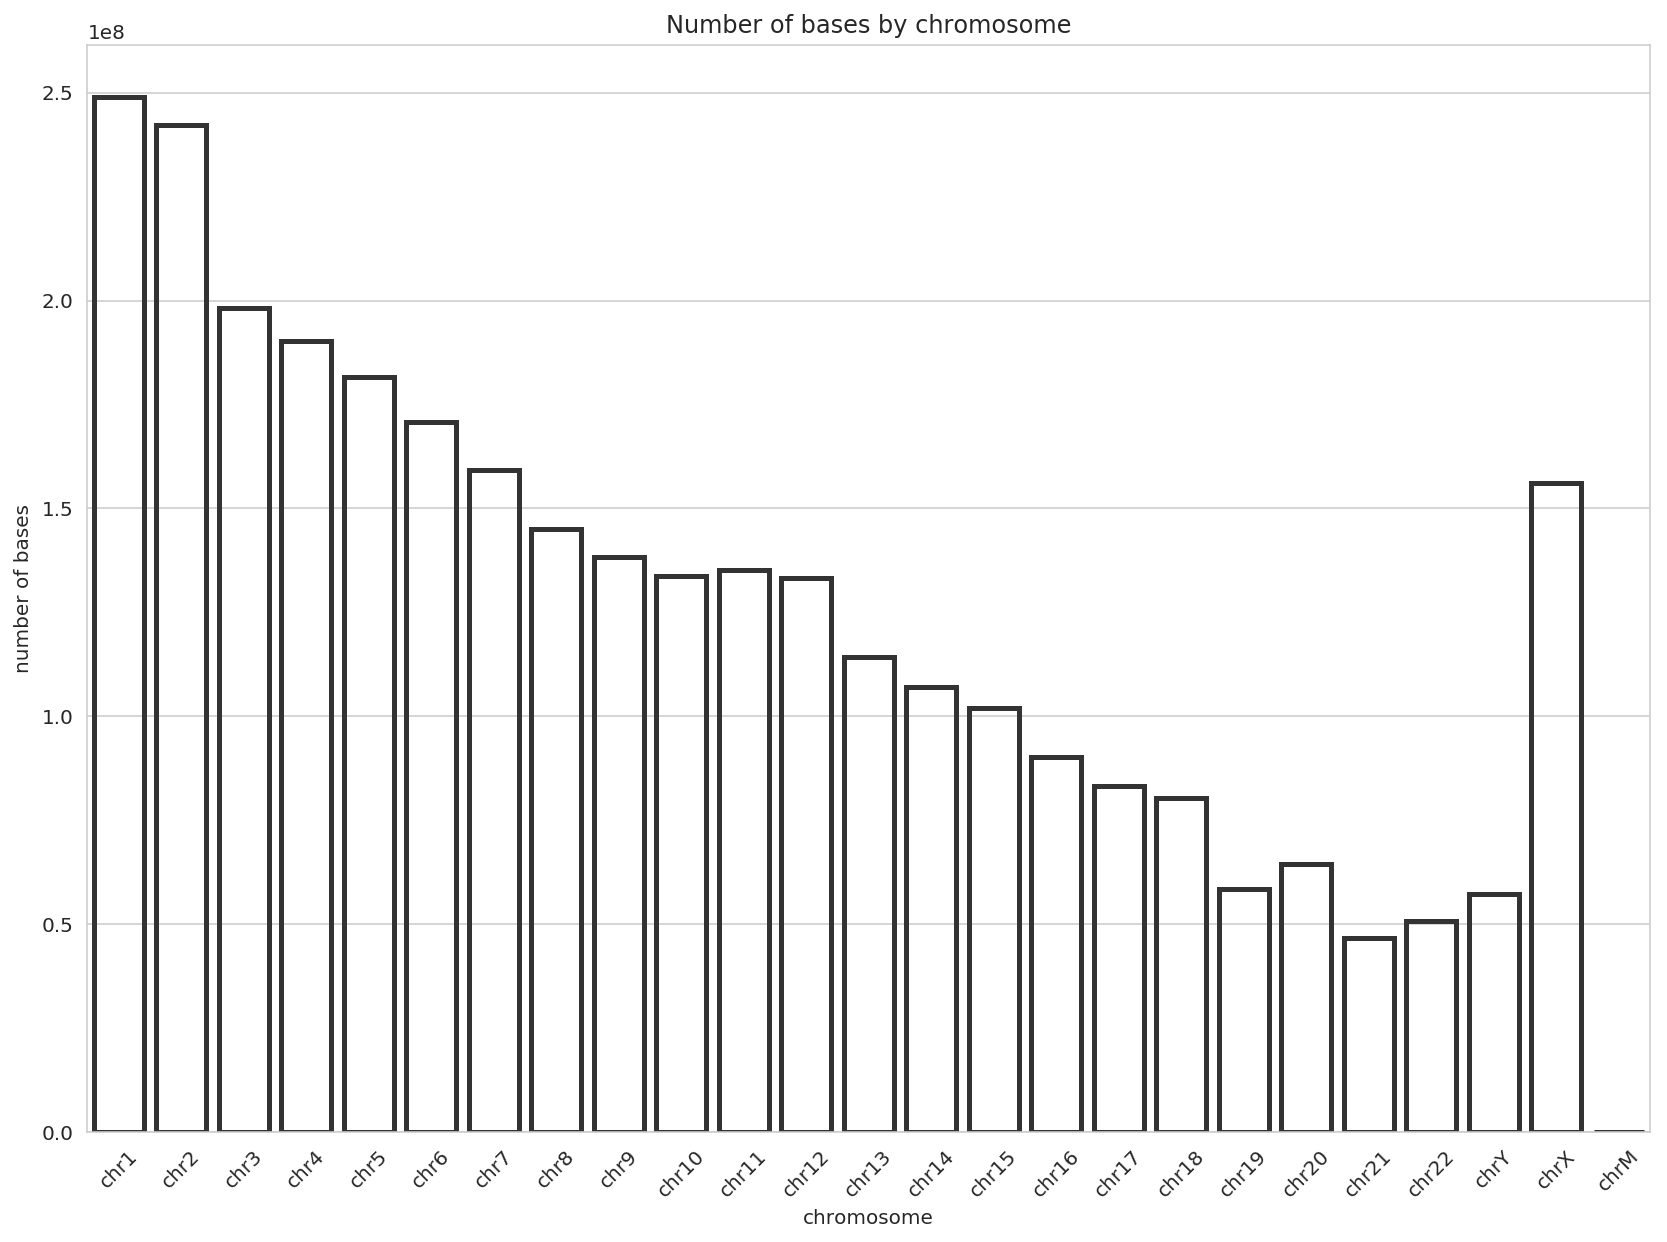

In [54]:
sns.set_style('whitegrid')
make_bar_chart(
    sorted_chroms,
    xlab='chromosome',
    ylab='number of bases',
    title='Number of bases by chromosome'
);

We can also use the *stats* method to compute aggregate statistics on a chromosome over a given range. For example to compute the mean signal value of the first 100 bases of chromosome 17:

In [38]:
bw.stats('chr17', 0, 100, exact=True)

[0.0007699999841861427]

Or to find the max value over the entire range of chromosome 17: 

In [40]:
bw.stats('chr17', 0, bw.chroms('chr17'), type='max', exact=True)

[423.7647399902344]

We can perform these computations for every chromosome and plot. For average signal by chromosome:

In [49]:
avg_signal_by_chrom = []
for c in sorted_chroms:
    avg_signal_by_chrom.append((c[0], bw.stats(c[0], 0, c[1])[0]))
avg_signal_by_chrom

[('chr1', 1.3005658152563901),
 ('chr2', 0.9776824726180723),
 ('chr3', 1.0238815680325906),
 ('chr4', 0.7834790343024598),
 ('chr5', 0.9322115322711368),
 ('chr6', 1.1368057364490873),
 ('chr7', 1.0252035659113665),
 ('chr8', 0.9320086043993253),
 ('chr9', 0.9922476155425214),
 ('chr10', 1.0850530972238865),
 ('chr11', 1.3299167411700696),
 ('chr12', 1.3202504038610983),
 ('chr13', 0.6830104968901707),
 ('chr14', 1.0237604823132531),
 ('chr15', 1.0359834803254788),
 ('chr16', 1.4457444109034894),
 ('chr17', 2.1517265088460826),
 ('chr18', 0.7647825206159133),
 ('chr19', 3.4088046387918416),
 ('chr20', 1.3063209052745783),
 ('chr21', 0.6950082744932066),
 ('chr22', 1.3391294178415747),
 ('chrY', 0.0009752539631293383),
 ('chrX', 0.5172891474832746),
 ('chrM', 3.001066135247865)]

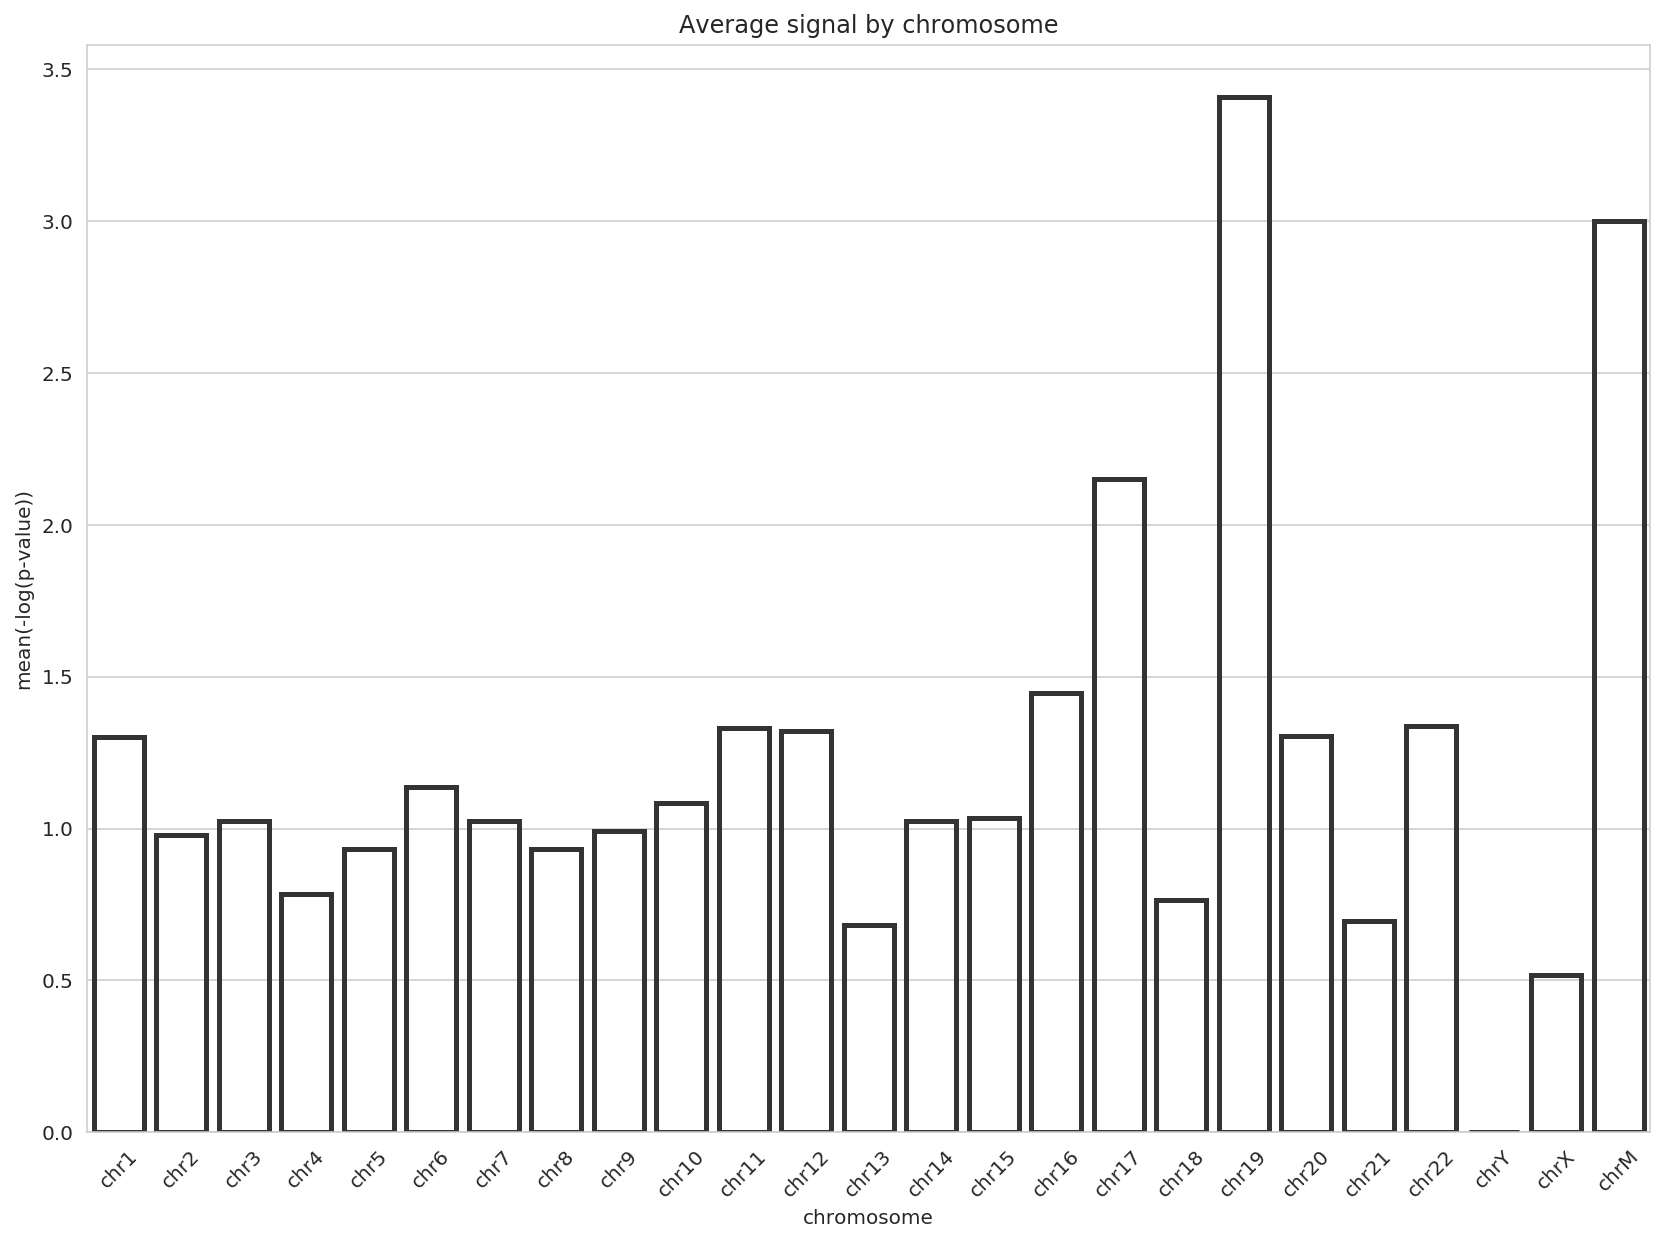

In [50]:
make_bar_chart(
    avg_signal_by_chrom,
    xlab='chromosome',
    ylab='mean(-log(p-value))',
    title='Average signal by chromosome'
);

And max signal by chromosome:

In [51]:
max_signal_by_chrom = []
for c in sorted_chroms:
    max_signal_by_chrom.append((c[0], bw.stats(c[0], 0, c[1], type='max')[0]))
max_signal_by_chrom

[('chr1', 410.26885986328125),
 ('chr2', 417.2301025390625),
 ('chr3', 415.2379455566406),
 ('chr4', 419.1672668457031),
 ('chr5', 400.9221496582031),
 ('chr6', 408.64996337890625),
 ('chr7', 408.7212219238281),
 ('chr8', 404.7070007324219),
 ('chr9', 404.4859924316406),
 ('chr10', 408.6165466308594),
 ('chr11', 418.18035888671875),
 ('chr12', 404.65386962890625),
 ('chr13', 399.56427001953125),
 ('chr14', 411.5511779785156),
 ('chr15', 415.4698181152344),
 ('chr16', 413.7628173828125),
 ('chr17', 423.7647399902344),
 ('chr18', 386.75360107421875),
 ('chr19', 412.6766052246094),
 ('chr20', 419.4826354980469),
 ('chr21', 395.0758056640625),
 ('chr22', 400.1557922363281),
 ('chrY', 4.8051300048828125),
 ('chrX', 429.1736755371094),
 ('chrM', 12.74219036102295)]

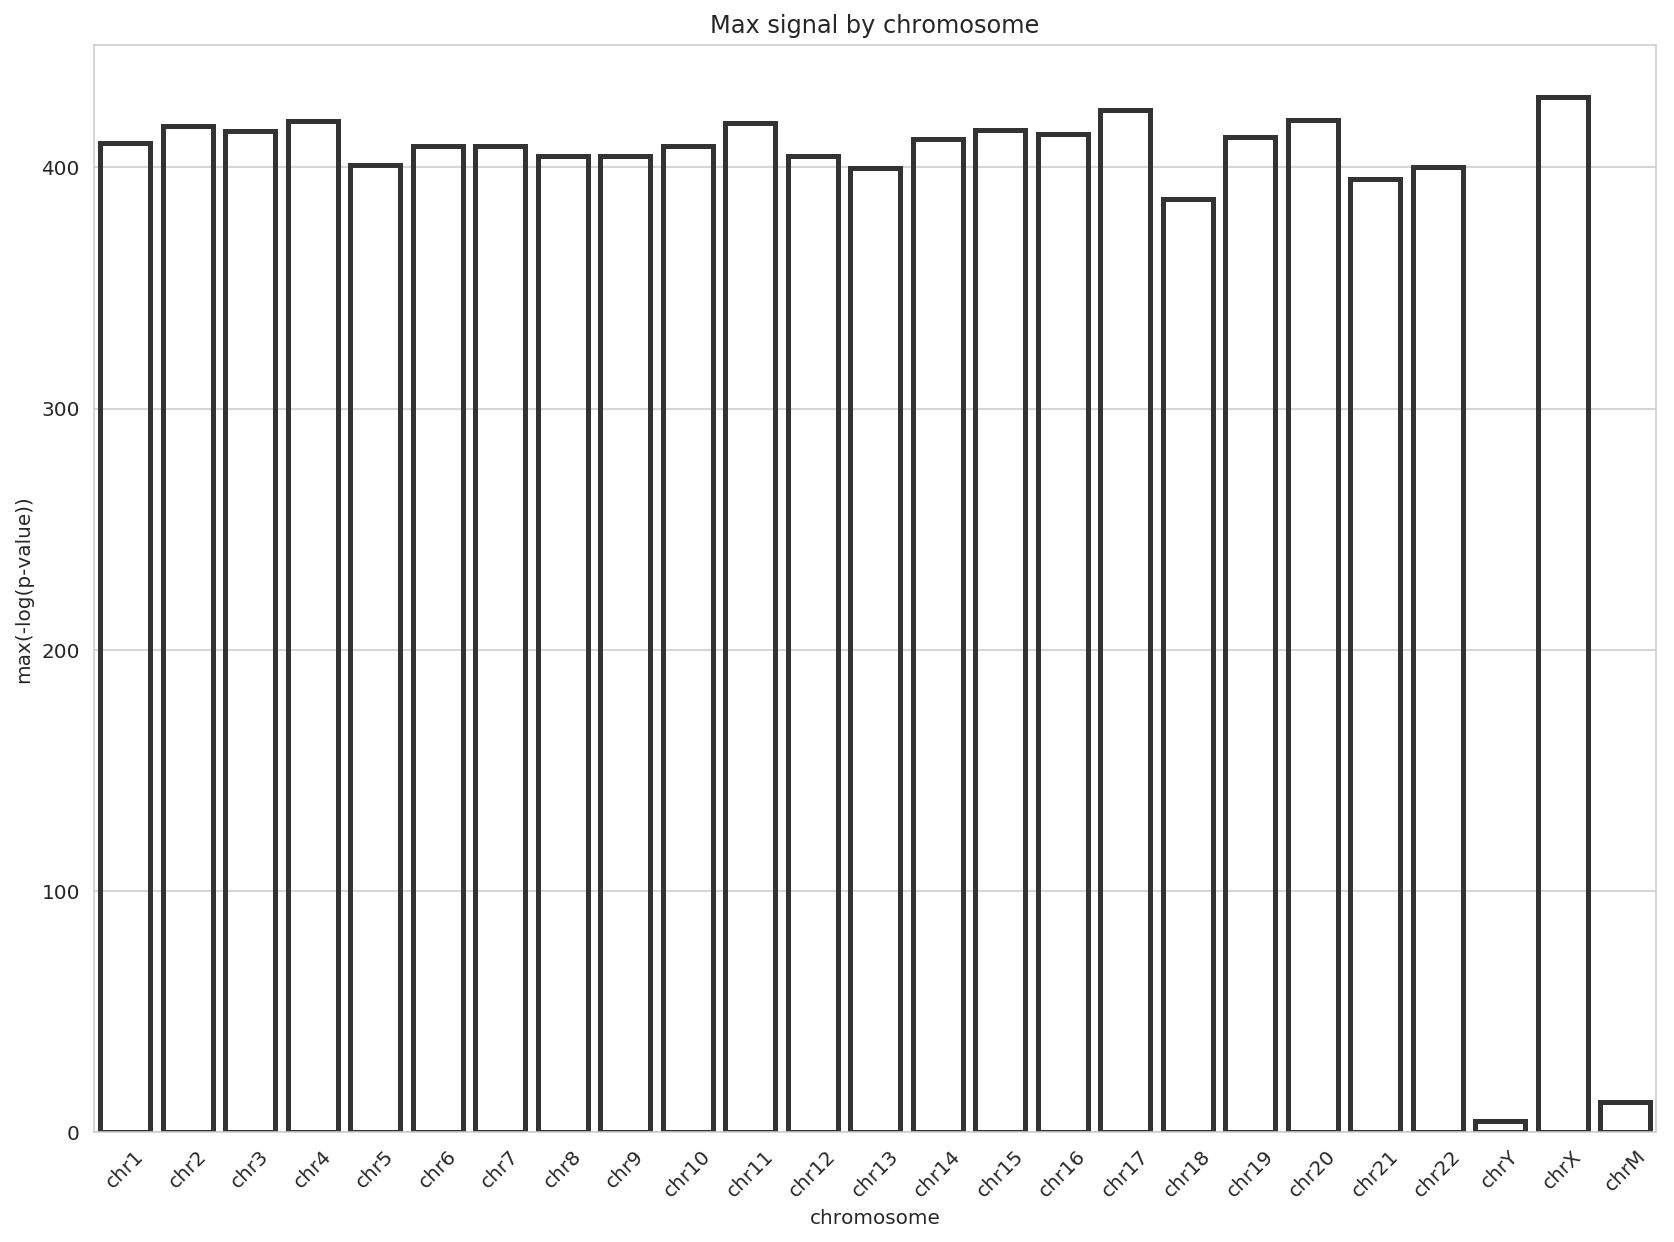

In [52]:
make_bar_chart(
    max_signal_by_chrom,
    xlab='chromosome',
    ylab='max(-log(p-value))',
    title='Max signal by chromosome'
);

We can also return a *numpy* array of signal values over a certain range.

In [66]:
bw.values('chr19', 115000, 160000, numpy=True)

array([0.00077, 0.00077, 0.00077, ..., 0.00077, 0.00077, 0.00077],
      dtype=float32)